<a href="https://colab.research.google.com/github/carlosramos1/practicas-machine-learning/blob/main/Reconocimiento_de_digitos_manuscritos_Redes_Convolucionales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de números manuscritos con Redes Convoluciones

In [28]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Lectura de Dataset

In [2]:
import kagglehub
path = kagglehub.dataset_download("olafkrastovski/handwritten-digits-0-9")
print("Path to dataset files:", path)

# fuente: https://www.kaggle.com/datasets/olafkrastovski/handwritten-digits-0-9?resource=download

100%|██████████| 66.7M/66.7M [00:00<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/olafkrastovski/handwritten-digits-0-9/versions/2


In [3]:
!ls /root/.cache/kagglehub/datasets/olafkrastovski/handwritten-digits-0-9/versions/2

0  1  2  3  4  5  6  7	8  9


In [4]:
path_dir = '/root/.cache/kagglehub/datasets/olafkrastovski/handwritten-digits-0-9/versions/2'

In [38]:
# cargamos las imágenes en escala de grises y con sus respectivas clases
images = []
classes =  []

for subdir in range(10):
    path = os.path.join(path_dir, str(subdir))
    for img in os.listdir(path):
        images.append(cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE))
        classes.append(subdir)
print('Total imágenes: ', len(images))
print('Total etiquetas: ', len(classes))


Total imágenes:  21555
Toral etiquetas:  21555


In [39]:
# Verificamos que hay solamente 10 clases
np.unique(classes)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

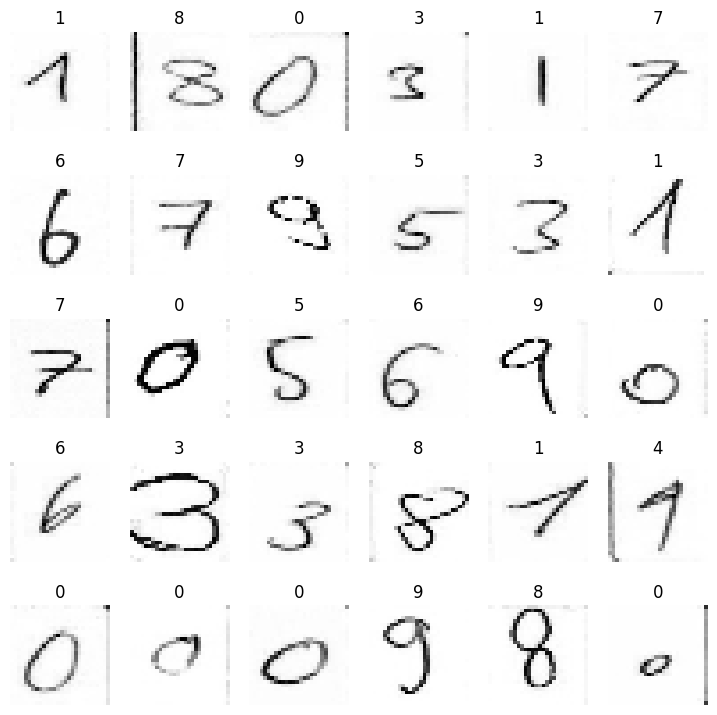

In [72]:
# Mostramos algunas imágenes aleatoriamente
from random import randrange, seed
seed(1)

fig, ax = plt.subplots(5, 6, figsize=(9, 9))

for i in range(5):
  for j in range(6):
    n_ran = randrange(0, len(images)-1)
    ax[i][j].imshow(images[n_ran], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].set_title(classes[n_ran])
plt.show()

## Preparación del dataset

In [13]:
# segun la doc. del dataset, las imagenes son 140x90 px
# HEIGHT_IMG = 140
# WIDTH_IMG = 90

In [41]:
#reducir el tamaño de las imagenes
HEIGHT_IMG = 28
WIDTH_IMG = 28
images = [cv2.resize(img, (28, 28)) for img in images]

In [42]:
# Definimos la matriz de datos 'X' y el vector de respuestas 'y'
X = np.array([img.reshape(HEIGHT_IMG,WIDTH_IMG,1) for img in images])
y = np.array(classes)

print('Tamaño de X: ', X.shape)
print('Tamaño de y: ', y.shape)

Tamaño de X:  (21555, 28, 28, 1)
Tamaño de y:  (21555,)


In [45]:
# Dividir datos de entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Codificación dummy del vector y_train y y_test
from sklearn.preprocessing import label_binarize

y_train_bin = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9])
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])

# Mostramos los primeros 5 numeros codificados
y_train[:5], y_train_bin[:5]

(array([8, 7, 0, 6, 2]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]))

## Red Neuronal Convolucional

- Esta topología de red convolucional tiene como referencia: https://medium.com/@fabidg142517/aplicaci%C3%B3n-de-redes-neuronales-en-el-reconocimiento-de-caracteres-escritos-a-mano-a6cf4887055e

In [47]:
from keras.models import Sequential
from keras import layers

In [48]:
# Definimos el modelo
model_cnn = Sequential([
  layers.Input(shape=(HEIGHT_IMG,WIDTH_IMG,1)),
  layers.Conv2D(32, (3,3), input_shape=(HEIGHT_IMG,WIDTH_IMG,1), activation='relu'),
  layers.MaxPooling2D(2,2),

  layers.Conv2D(64, (3,3), input_shape=(28,28,1), activation='relu'),
  layers.MaxPooling2D(2,2),

  layers.Dropout(0.5),

  layers.Flatten(),
  layers.Dense(units=100, activation='relu'),

  layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model_cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │       160,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 179,926 (702.84 KB)

 Trainable params: 179,926 (702.84 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
model_cnn_fit = model_cnn.fit(X_train, y_train_bin, epochs=10, batch_size=128, validation_data=(X_test, y_test_bin))

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step - accuracy: 0.8350 - loss: 0.5072 - val_accuracy: 0.9091 - val_loss: 0.2986
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.8473 - loss: 0.4749 - val_accuracy: 0.9255 - val_loss: 0.2524
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.8592 - loss: 0.4334 - val_accuracy: 0.9279 - val_loss: 0.2268
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.8816 - loss: 0.3640 - val_accuracy: 0.9362 - val_loss: 0.2220
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.8912 - loss: 0.3321 - val_accuracy: 0.9425 - val_loss: 0.1852
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.9022 - loss: 0.3089 - val_accuracy: 0.9464 - val_loss: 0.1809
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9137 - loss: 0.2721 - val_accuracy: 0.9497 - val_loss: 0.1738
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9139 - loss: 0.2627 - 

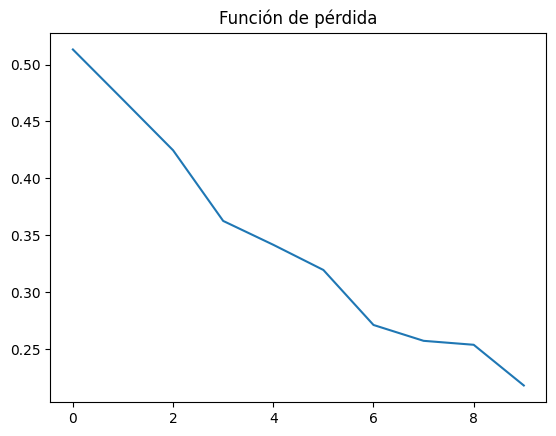

In [62]:
# Graficar la función de perdida
plt.plot(model_cnn_fit.history.get('loss'))
plt.title("Función de pérdida")
plt.show()

## Validación

Predicción para los **datos de entrenamiento**

In [64]:
y_hat_train = model_cnn.predict(X_train)
y_hat_train = np.argmax(y_hat_train,1)
y_hat_train[:5], y_train[:5]

539/539 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


(array([8, 7, 0, 6, 2]), array([8, 7, 0, 6, 2]))

In [65]:
cm = confusion_matrix(y_hat_train, y_train)
cm

array([[1817,    0,    1,    0,    3,    1,    0,    0,    2,    3],
       [   0, 1743,    1,    0,   15,    0,    2,    1,    2,    0],
       [   2,    3, 1753,   11,    1,    0,    0,   12,    5,    4],
       [   2,    0,    4, 1722,    0,    1,    1,    3,    6,    3],
       [   2,    1,    0,    0, 1719,    0,    0,    2,    2,    4],
       [   2,    0,    0,    2,    0, 1693,    3,    2,    6,    1],
       [  15,    1,    1,    0,    9,    4, 1678,    0,   14,    2],
       [   0,    0,    2,    2,    0,    1,    0, 1690,    2,    0],
       [   1,    0,    3,   14,    0,    2,    5,    1, 1605,   14],
       [   3,    4,    1,    5,    6,    5,    0,    3,   14, 1574]])

In [66]:
# taza de presición
np.diag(cm).sum()/len(y_train)

np.float64(0.9855022036650429)

Predicciones para los **datos de prueba**

In [67]:
y_hat_test = model_cnn.predict(X_test)
y_hat_test = np.argmax(y_hat_test,1)
y_hat_test[:5], y_test[:5]

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


(array([3, 5, 1, 5, 8]), array([3, 5, 1, 5, 8]))

In [68]:
cm = confusion_matrix(y_hat_test, y_test)
cm

array([[377,   0,   0,   0,   0,   0,   4,   0,   1,   1],
       [  1, 484,   1,   0,   3,   1,   1,   4,   0,   0],
       [  2,   1, 459,   2,   3,   0,   1,   8,   1,   3],
       [  0,   0,   2, 427,   0,   3,   0,   1,   2,   1],
       [  1,   1,   0,   0, 401,   0,   1,   1,   1,   7],
       [  2,   0,   0,   2,   0, 401,   1,   0,   1,   0],
       [  7,   0,   0,   0,   7,   3, 419,   0,   3,   0],
       [  0,   3,   1,   1,   0,   1,   0, 385,   0,   0],
       [  0,   0,   1,   6,   1,   4,   4,   0, 410,   3],
       [  2,   0,   3,   8,  11,   6,   1,   3,   8, 396]])

In [69]:
# taza de aciertos
np.diag(cm).sum()/len(y_test)

np.float64(0.9647413593133843)